In [282]:
from ctse.sysdata.csv_ctse_strategy_backtest_data import csvCTSEStrategyBacktestData
from sysdata.csv.csv_multiple_prices import csvFuturesMultiplePricesData
import pandas as pd
import numpy as np
from ctse.sysobjects.ctse_strategy_backtest import ctseStrategyBacktest
from sysdata.csv.csv_instrument_data import csvFuturesInstrumentData
from itables import show
import matplotlib.pyplot as plt

def select(se, start, end):
    return se[(se.index >= start) &(se.index <= end)]

# ins = pd.Series(csvFuturesInstrumentData('ctse.data.csvconfig').get_list_of_instruments()).sample(1).iloc[0]
# ins = 'C'
# print(ins)
notional_capital = 100_0000
ins_data = csvFuturesInstrumentData('ctse.data.csvconfig')

def experiment(leverage = 2, rounding = False, plotting = False):
    
    
    '''
    @ discrete system
    @ open price time series
        | current period |--next price--| next period |

    Time Index Symantics:
        Forecast: ex-ante
        Position: ex-post
        Transaction: ex-post, Position change
        PnL: ex-post
    '''

    meta_data = ins_data.get_instrument_data(ins).meta_data
    pointsize = meta_data.Pointsize
    transaction_cost_percentage = meta_data.Percentage
    # print(pointsize)
    # print(transaction_cost_percentage)

    '''
    Forecast
    '''
    backtest = csvCTSEStrategyBacktestData().read('1_B', ins, 'dma_long', cols=[ctseStrategyBacktest.STATE_FLAG, ctseStrategyBacktest.OPEN, ctseStrategyBacktest.CLOSE, ctseStrategyBacktest.OPERATE, ctseStrategyBacktest.NAV])
    backtest.loc[:, 'forecast'] = backtest[ctseStrategyBacktest.STATE_FLAG].replace(np.nan, 0)
    backtest.loc[:, 'entry_transaction'] = ((backtest.forecast.shift(1).diff() == 1) * 1)
    backtest.loc[:, 'holding'] = backtest.forecast.shift(1)
    backtest.loc[:, 'exit_transaction'] = ((backtest.forecast.shift(1).diff() == -1) * 1)
    fill = backtest.loc[backtest[ctseStrategyBacktest.OPERATE].replace(np.nan, '').str.contains('止损')]
    backtest.loc[fill.index, 'tr_fill_price'] = fill[ctseStrategyBacktest.OPERATE].apply(lambda s: float(s.split('_')[-1]))
    backtest = backtest.drop(ctseStrategyBacktest.STATE_FLAG, axis=1)

    contract = csvFuturesMultiplePricesData('ctse.data.multiple_prices_csv')._get_multiple_prices_without_checking(ins, check_data=False)[['PRICE_CONTRACT', 'PRICE', 'CLOSE', 'FORWARD_CLOSE']]
    # rolling
    # df.loc[df['FORWARD'].notna(), 'FORWARD'] = df['CLOSE']
    # df.loc[df['FORWARD'].shift(-1).notna(), 'FORWARD'] = df.PRICE.shift(-1)
    # df.loc[:, 'one_contract_rolling_cost'] = df['FORWARD_CLOSE'].diff().shift(-1) * df.CLOSE / df.FORWARD_CLOSE

    df = pd.concat([backtest, contract], axis=1)

    '''
    Position Sizing
        0. ideal
        1. full notional capital
        2. no, rounding, continuous
    '''
    if rounding:
        df.loc[:, 'ideal_position'] = (
            ((df.holding == 1) * notional_capital * leverage // (df.PRICE * pointsize))
        )
    else:
        df.loc[:, 'ideal_position'] = (
            ((df.holding == 1) * notional_capital * leverage / (df.PRICE * pointsize))
        )


    '''
    PnL
    '''
    ## 1.entry transaction pnl
    df.loc[:, 'fixed_capital_entry_transaction_pnl'] = (
        df.entry_transaction * df.ideal_position
        * df.PRICE * pointsize * -transaction_cost_percentage).shift(-1)

    ## 2.position pnl
    ### same contract
    df.loc[:, 'one_same_contract_pnl'] = df.PRICE.shift(-1).diff() * pointsize
    ### rolling contract
    df.loc[:, 'one_rolling_contract_pnl'] = (
        (contract.PRICE_CONTRACT != contract.PRICE_CONTRACT.shift(-1))
        * ((df.CLOSE - df.PRICE) + df.PRICE.shift(-1) - df.FORWARD_CLOSE) * pointsize
        )
    ### Fill Price for transcation
    df.loc[:, 'Fill_Price'] = df.tr_fill_price / df[ctseStrategyBacktest.OPEN] * df.PRICE
    df.loc[:, 'one_filled_contract_pnl'] = ((df['Fill_Price'] - df.PRICE) * pointsize)
    ### Actual Contract PnL
    df.loc[:, 'one_actual_contract_pnl'] = df.one_same_contract_pnl
    df.loc[df.one_rolling_contract_pnl.notna(), 'one_actual_contract_pnl'] = df.one_rolling_contract_pnl
    df.loc[df.one_filled_contract_pnl.notna(), 'one_actual_contract_pnl'] = df.one_filled_contract_pnl
    df.loc[:, 'fixed_capital_position_pnl'] = df.ideal_position * df.one_actual_contract_pnl

    ## 3.exit transaction pnl
    df.loc[:, 'fixed_capital_exit_transaction_pnl'] = (
        df.exit_transaction * df.ideal_position.shift(1)
        * df.PRICE * pointsize * -transaction_cost_percentage).shift(-1)

    df.loc[:, 'fixed_capital_net_pnl'] = (
        df.fixed_capital_entry_transaction_pnl.replace(np.nan, 0)
        + df.fixed_capital_position_pnl.replace(np.nan, 0)
        + df.fixed_capital_exit_transaction_pnl.replace(np.nan, 0)
        ).replace(np.nan, 0)
    # df = df.loc[:, ctseStrategyBacktest.NAV] = column_nav


    t1 = (df.fixed_capital_net_pnl / notional_capital)
    # t1 = select(t1, '2020-12-01', '2021-02-01')0
    t2 = df.tr_nav_of_product.pct_change()
    # t2 = select(t2, '2020-12-01', '2021-02-01')
    # t1.plot(legend=True)
    # t2.plot()

    start = '2010-07-01'
    end = '2030-07-30'
    # start = '2014-07-01'
    # end = '2014-07-30'

    if plotting:
        (1+t1).cumprod().rename('{}*{}'.format(ins, leverage)).plot(legend=True, alpha=0.5)
        (1+t2).cumprod().plot(legend=True, alpha=0.5)

    navs = (1+t1).cumprod()
    nav = navs.iloc[-1]
    sharpe = t1.mean() / t1.std()
    mdd = ((navs - navs.expanding().max()) / navs.expanding().max()).min()
    return (nav, mdd, navs, df.fixed_capital_net_pnl, df)

    # show(select(pd.concat([t1, t2], axis=1), start, end))

    # # pretty
    # column_nav = df.pop(ctseStrategyBacktest.NAV)
    # df.loc[:, ctseStrategyBacktest.NAV] = column_nav
    # show(select(df, start, end))

ins_2_navs = {}
ins_2_mdds = {}
for ins in csvFuturesInstrumentData('ctse.data.csvconfig').get_list_of_instruments()[:]:
    if ins in ['IC', 'IF']:
        continue
    navs = []
    mdds = []
    for i in range(1, 10):
        nav, mdd, _, _, _= experiment(i, rounding=True)
        navs.append(nav)
        mdds.append(mdd)
    ins_2_navs[ins] = navs
    ins_2_mdds[ins] = mdds


In [269]:
display(pd.DataFrame(ins_2_navs).T.style.highlight_max(color = 'green', axis=1))
display(pd.DataFrame(ins_2_mdds).T)

,0,1,2,3,4,5,6,7,8
A,1.322292,1.622238,1.803995,1.868943,1.739790,1.493095,1.175095,0.840938,0.537502
AG,1.879085,3.110162,4.665141,5.922772,6.797241,6.723220,5.905538,4.451931,2.937068
AL,2.083254,3.983080,6.568853,8.979961,10.541606,9.914506,6.816941,2.605172,-1.406203
AP,1.757275,2.913436,4.409910,6.022573,7.619327,8.559354,9.110608,8.478616,7.256875
AU,1.409033,2.082981,2.860647,3.774961,4.361520,5.658584,6.152162,6.646191,6.719062
BU,1.160514,1.260359,1.273244,1.203656,1.061554,0.868312,0.662330,0.471736,0.308626
C,1.478513,2.093330,2.822655,3.625134,4.449394,5.194695,5.780508,6.128491,6.155043
CF,1.709278,2.717520,3.868272,5.131614,6.122113,6.670877,6.658186,6.218268,5.237339
CU,1.854511,3.436243,6.246834,9.810938,14.669107,20.559645,27.231469,32.955820,37.111350
EG,1.713182,2.583780,3.388979,3.853313,3.831155,3.242520,2.413832,1.554643,0.829642


,0,1,2,3,4,5,6,7,8
A,-0.160980,-0.302791,-0.427156,-0.532471,-0.623086,-0.699123,-0.768637,-0.839561,-0.895023
AG,-0.126919,-0.247612,-0.362277,-0.479617,-0.584216,-0.680060,-0.768632,-0.840414,-0.896170
AL,-0.144957,-0.281716,-0.410298,-0.542742,-0.654457,-0.758001,-0.863929,-0.950949,-1.043400
AP,-0.131134,-0.249913,-0.355227,-0.447812,-0.531482,-0.604574,-0.666637,-0.721568,-0.768814
AU,-0.098199,-0.206398,-0.300607,-0.381602,-0.487415,-0.550663,-0.616996,-0.671095,-0.734591
BU,-0.161866,-0.307925,-0.435101,-0.545983,-0.639229,-0.717747,-0.782608,-0.835010,-0.877045
C,-0.107131,-0.206043,-0.295646,-0.377542,-0.450504,-0.516687,-0.575741,-0.629017,-0.676129
CF,-0.146817,-0.281592,-0.400653,-0.503087,-0.590092,-0.674676,-0.750616,-0.818996,-0.871381
CU,-0.105906,-0.228488,-0.338025,-0.431486,-0.518388,-0.589445,-0.655681,-0.714980,-0.766012
EG,-0.147764,-0.291842,-0.420528,-0.535183,-0.634704,-0.729732,-0.807149,-0.866898,-0.913371


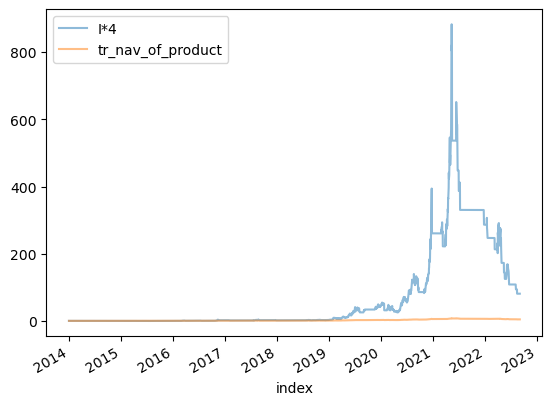

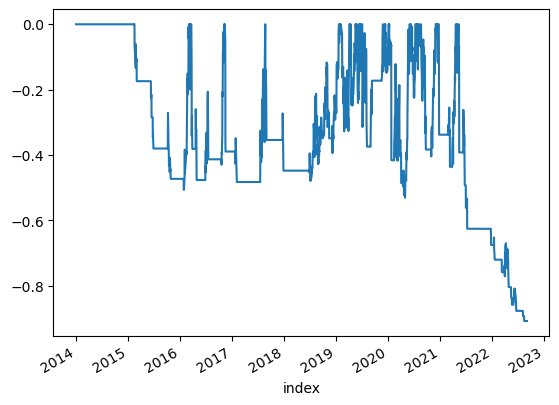

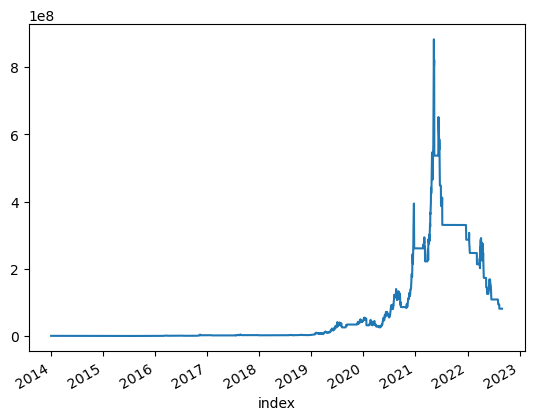

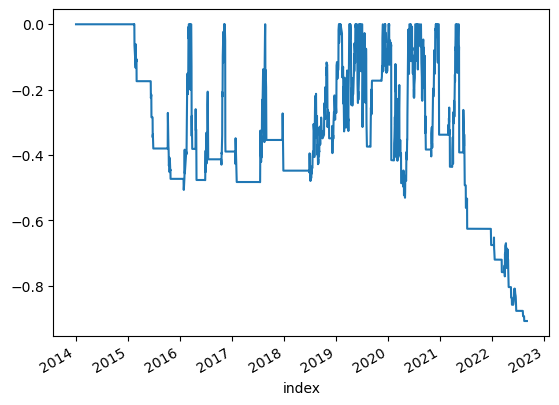

In [241]:
ins = 'I'
# experiment(1, rounding=True, plotting=True)
_,_,navs,pnls = experiment(4, rounding=False, plotting=True)
((navs - navs.expanding().max())/navs.expanding().max()).plot()
plt.show()

# fixed_pnls = pnls.cumsum() + notional_capital
# fixed_pnls.plot()
# plt.show()
# ((fixed_pnls - fixed_pnls.expanding().max())/fixed_pnls.expanding().max()).plot()
# plt.show() 

compound_pnls = (pnls * navs.shift(1)).cumsum() + notional_capital
compound_pnls.plot()
plt.show()
((compound_pnls - compound_pnls.expanding().max())/compound_pnls.expanding().max()).plot()
plt.show()



In [271]:
ins = 'I'
meta_data = ins_data.get_instrument_data(ins).meta_data
pointsize = meta_data.Pointsize
transaction_cost_percentage = meta_data.Percentage
# experiment(1, rounding=True, plotting=True)
_,_,navs,pnls,df = experiment(4, rounding=False, plotting=False)

sim_notional_capital = notional_capital
pre_row = None
num_contract = 0
for time, row in df.iterrows():
    if pre_row is None:
        pre_row = row
        continue
    
    if row.entry_transaction == 1:
        num_contract = sim_notional_capital * (1 - transaction_cost_percentage) // (row.PRICE * pointsize)
        sim_notional_capital -= num_contract * (row.PRICE * pointsize) * transaction_cost_percentage
    
    if row.holding == 1:
        
        

    pre_row = row


20.0
22.0
22.0
26.0
30.0
31.0
21.0
24.0
22.0
15.0
20.0
18.0
18.0
21.0
21.0
19.0
21.0
16.0
16.0
15.0
16.0
15.0
16.0
12.0
11.0
8.0
9.0
8.0
8.0
8.0
14.0
13.0
11.0
11.0
12.0
11.0
11.0
12.0
13.0


5.402368261139659


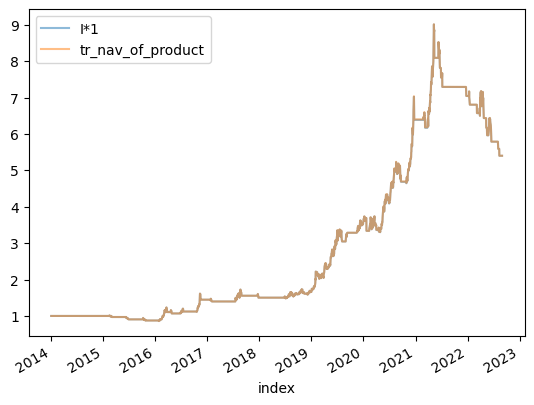

In [286]:
ins = 'I'
# experiment(1, rounding=True, plotting=True)
rounding = False
_,_,navs,pnls,df = experiment(1, rounding, plotting=True)
# _,_,navs,pnls,_ = experiment(2, rounding, plotting=True)
# _,_,navs,pnls,_ = experiment(3, rounding, plotting=True)
# _,_,navs,pnls = experiment(4, rounding, plotting=True)
# print(navs.iloc[-1])
# _,_,navs,pnls = experiment(5, rounding, plotting=True)

In [3]:
df.sort_values(['fixed_capital_net_pnl'], ascending=False)

df.loc[:, 'ideal_position'] = 0
df.loc[df.holding == 1, 'ideal_position'] = np.nan
df.loc[df.entry_transaction == 1, 'ideal_position'] = (df.entry_transaction * notional_capital / (df.PRICE * pointsize))
df.ideal_position.ffill(inplace=True)

## 2.rolling pnl
df.loc[:, 'one_contract_rolling_cost'] = (-df.FORWARD_CLOSE + df.CLOSE) * pointsize
df.loc[:, 'fixed_capital_rolling_pnl'] = (
    df.ideal_position * (df.ideal_position.shift(-1) != 0)
    * df.one_contract_rolling_cost
    )

,tr_the_open_price,tr_the_close_price,tr_operate,forecast,entry_transaction,holding,exit_transaction,tr_fill_price,PRICE_CONTRACT,PRICE,...,fixed_capital_rolling_pnl,one_same_contract_pnl,one_rolling_contract_pnl,Fill_Price,one_filled_contract_pnl,one_actual_contract_pnl,fixed_capital_position_pnl,fixed_capital_exit_transaction_pnl,fixed_capital_net_pnl,tr_nav_of_product
index,,,,,,,,,,,,,,,,,,,,,
2016-02-19,2294.909207,2277.247002,0_2258.064651082729,1.0,0.0,1.0,0.0,NaN,20160500,1949,...,143305.439331,-2890.0,-150.0,NaN,NaN,-150.0,-7845.188285,-0.0,135460.251046,1.068271
2014-07-14,2438.433121,2449.503185,0_2414.144514723069,1.0,0.0,1.0,0.0,NaN,20140900,2423,...,56397.306397,-1250.0,90.0,NaN,NaN,90.0,3787.878788,-0.0,60185.185185,1.023315
2016-11-10,2275.400473,2352.213356,0_2158.18137021043,1.0,0.0,1.0,0.0,NaN,20170100,1570,...,NaN,620.0,NaN,NaN,NaN,620.0,42494.859493,-0.0,42494.859493,1.191633
2020-07-27,2630.194196,2724.503948,0_2546.48677246099,1.0,0.0,1.0,0.0,NaN,20200900,2259,...,NaN,890.0,NaN,NaN,NaN,890.0,42020.774315,-0.0,42020.774315,1.345573
2020-08-14,2628.599721,2711.260090,0_2591.828072182247,1.0,0.0,1.0,0.0,NaN,20210100,2226,...,NaN,700.0,NaN,NaN,NaN,700.0,33050.047214,-0.0,33050.047214,1.334470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-22,2271.052574,2229.022884,0_2184.217479884595,1.0,0.0,1.0,0.0,NaN,20170100,1567,...,NaN,-430.0,NaN,NaN,NaN,-430.0,-27670.527671,-0.0,-27670.527671,1.039007
2017-12-04,2414.383666,2424.255562,0_2367.9344903724977,1.0,0.0,1.0,0.0,NaN,20180100,1712,...,-32544.378698,580.0,30.0,NaN,NaN,30.0,1775.147929,-0.0,-30769.230769,1.205088
2020-11-02,3098.582960,3014.741729,0_2961.1835680752597,1.0,0.0,1.0,0.0,NaN,20210100,2624,...,NaN,-690.0,NaN,NaN,NaN,-690.0,-32577.903683,-0.0,-32577.903683,1.485004
